# Install and import dependencies

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

Load imports

In [1]:
from transformers import pipeline

from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load classifier

In [2]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", revision="c626438", device="mps")

In [3]:
sample_rename_mappings = {
  "Interested in products or services": "random",
  "Requests": "video request",
  "Compliments": "compliment",
  "Questions (can be potential leads)": "question",
  "Hate Speech": "hate_speech",
  "Random": "random",
  "Problems with products or services": "problem"
}
classifier_labels = [v for k,v in sample_rename_mappings.items()]

In [4]:
result = classifier(
    "Dear Marina,I just wanted to say a big thank you for your amazing YouTube content that has helped me improve my English so much! 🙌📚 Your videos are awesome, and I'm truly grateful for all the valuable lessons and tips you share. Keep up the fantastic work! 💓👏🌟",
    candidate_labels=classifier_labels,
)
result


{'sequence': "Dear Marina,I just wanted to say a big thank you for your amazing YouTube content that has helped me improve my English so much! 🙌📚 Your videos are awesome, and I'm truly grateful for all the valuable lessons and tips you share. Keep up the fantastic work! 💓👏🌟",
 'labels': ['compliment',
  'video request',
  'question',
  'problem',
  'random',
  'random',
  'hate_speech'],
 'scores': [0.7603687047958374,
  0.15332449972629547,
  0.029150063171982765,
  0.022072985768318176,
  0.014438104815781116,
  0.014438104815781116,
  0.0062075089663267136]}

In [5]:
def process_text(text: str):
    classifications = classifier(text, classifier_labels)
    scores = classifications["scores"]

    return pd.Series({f"pred_{label}": score for label, score in zip(classifier_labels, scores)})

# Test classifier on sample dataset

In [6]:
df = pd.read_csv("sample.csv")
df.head()

,label,comment
0,Interested in products or services,"Yes Marina, It's essential for me to learn Eng..."
1,Interested in products or services,That's what I've always wanted
2,Interested in products or services,I am not a professional guy. I am just studyin...
3,Interested in products or services,Do you think it's still essential to learn Eng...
4,Interested in products or services,"Hi Marina, thanks for sharing these useful vid..."


In [7]:
y = "label"

# Rename labels
df[y] = df[y].replace(sample_rename_mappings)

df[y].value_counts()

label
random           15
video request     8
compliment        8
question          5
hate_speech       2
Name: count, dtype: int64

Total number of samples: 38


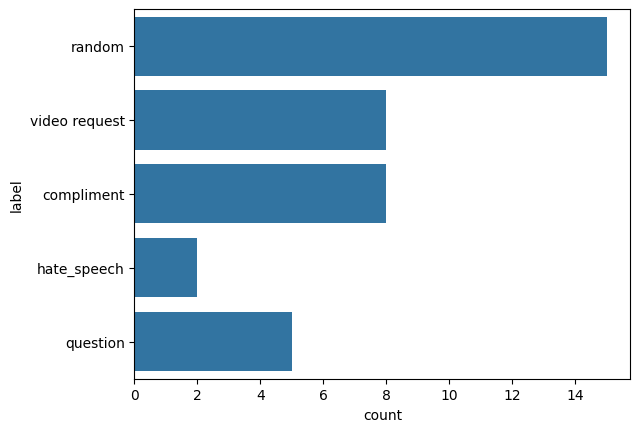

In [8]:
# plot distribution of labels
sns.countplot(df[y])

# write total number of samples
print(f"Total number of samples: {len(df)}")

In [9]:
# apply classifications
tqdm.pandas(desc='Assigning classifications')

X = "comment"
result_df = df[X].progress_apply(process_text)
df = pd.concat([df, result_df], axis=1)

Assigning classifications: 100%|██████████| 38/38 [01:03<00:00,  1.68s/it]


In [10]:
y_pred_values = [f"pred_{x}" for x in classifier_labels]

def get_highest_prediction_label(row):
  scores = {label: row[label] for label in y_pred_values}
  highest_label = max(scores, key=scores.get)
  return highest_label[5:]

In [11]:
y_pred = f"pred_{y}"

df[y_pred] = df.apply(get_highest_prediction_label, axis=1)
df[[y, y_pred]].head()

,label,pred_label
0,random,video request
1,random,video request
2,random,video request
3,random,video request
4,random,video request


<Axes: xlabel='count', ylabel='pred_label'>

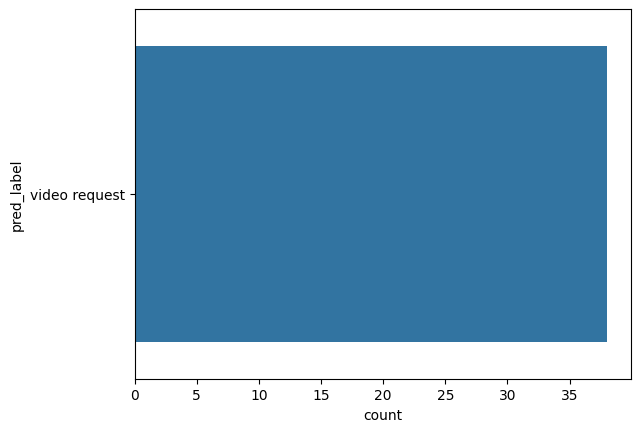

In [12]:
# plot distribution of predicted labels
sns.countplot(df[y_pred])

Find evaluation metrics

In [13]:
# Calculate accuracy
accuracy_score(df[y], df[y_pred])

0.21052631578947367

In [14]:
# Generate confusion matrix
cm = confusion_matrix(y_true=df[y], y_pred=df[y_pred])

In [15]:
# Generate a classification report, including precision, recall, and F1-score
print(classification_report(y_true=df[y], y_pred=df[y_pred]))

               precision    recall  f1-score   support

   compliment       0.00      0.00      0.00         8
  hate_speech       0.00      0.00      0.00         2
     question       0.00      0.00      0.00         5
       random       0.00      0.00      0.00        15
video request       0.21      1.00      0.35         8

     accuracy                           0.21        38
    macro avg       0.04      0.20      0.07        38
 weighted avg       0.04      0.21      0.07        38



/Users/flerovious/Documents/agent/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flerovious/Documents/agent/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/flerovious/Documents/agent/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

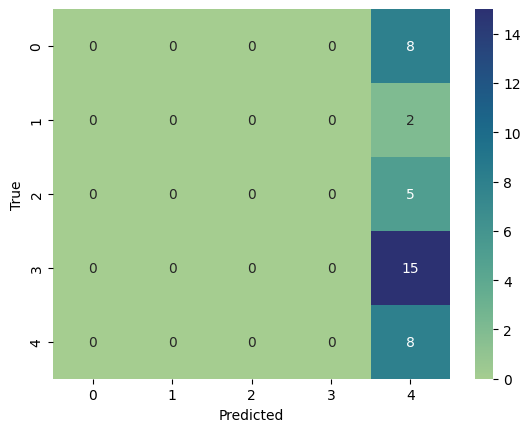

In [16]:
# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="crest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Save processed data

In [17]:
# save processed data
df.to_csv("sample_processed.csv")